# W207 Project - Phillip Ng

This code utilizes Tensorflow's recommendation systems library. First, the implementation below includes matrix factorization, which includes taking representative embeddings (or imaginary features) for each member and song and taking the dot product of the two. This will produce a (member)x(song) matrics. The highest ranked song for each member is then recommended. Second, the implementation includes a ranking system, where the rating is just the target value (if they listened to a song repeatedly, then they must have a higher rating of the song). 



## Imports


Let's first get our imports out of the way.


In [1]:
!pip install -q tensorflow-recommenders


     |████████████████████████████████| 61kB 2.7MB/s 
     |████████████████████████████████| 394.7MB 35kB/s 
     |████████████████████████████████| 3.7MB 5.7MB/s 


In [2]:
import os
import pprint
import tempfile

from typing import Dict, Text

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
import tensorflow_recommenders as tfrs

## Preparing the dataset

We're going to use the Movielens 100K dataset.

In [4]:
!mkdir .kaggle
!mv kaggle.json .kaggle
!mv .kaggle /root
!kaggle competitions download -c kkbox-music-recommendation-challenge
!7za -y x "*.7z" 

 93% 92.0M/98.8M [00:00<00:00, 121MB/s] 
100% 98.8M/98.8M [00:00<00:00, 183MB/s]
 92% 93.0M/101M [00:00<00:00, 132MB/s]
100% 101M/101M [00:00<00:00, 141MB/s] 
  0% 0.00/453k [00:00<?, ?B/s]
100% 453k/453k [00:00<00:00, 101MB/s]
 67% 28.0M/41.9M [00:00<00:00, 83.3MB/s]
100% 41.9M/41.9M [00:00<00:00, 139MB/s] 
  0% 0.00/1.29M [00:00<?, ?B/s]
100% 1.29M/1.29M [00:00<00:00, 104MB/s]
 91% 92.0M/101M [00:00<00:00, 121MB/s]
100% 101M/101M [00:00<00:00, 122MB/s] 

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         6 files, 361577170 bytes (345 MiB)
  0%    
Extracting archive: members.csv.7z
--
Path = members.csv.7z
Type = 7z
Physical Size = 1349856
Headers Size = 130
Method = LZMA2:3m
Solid = -
Blocks = 1

  0%    Everything is Ok

Extracting archive: sample_sub

In [5]:
train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')
members_df = pd.read_csv('members.csv')
songs_df = pd.read_csv('songs.csv')
extra_df = pd.read_csv('song_extra_info.csv')
# sample_df = pd.read_csv('sample_submission.csv')

Although the origional dataset has over 7M rows, we just use rows applicable to a certain amount of high usage users. Why? Beause the cold start problem in the dataset is a big problem. For a majority of the users, there are only a few songs listened to out of over 2M songs. Therefore, for most of the users, they'll have approximately the same recommendations since they have little listening history. In fact, there may be users without any data entries at all. To save on memory and computation, we'll just take into account 5 of the top listening users, as well as the songs that they have listened to. 

Text(0.5, 0, 'msno ID')

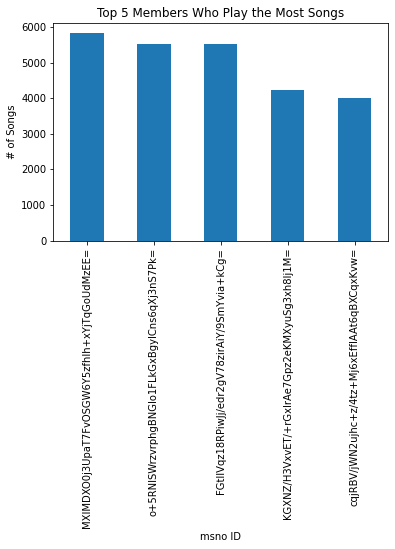

In [6]:
top_plays_df = train_df['msno'].value_counts()
ax = top_plays_df.head(5).plot.bar(rot=90)
ax.set_title('Top 5 Members Who Play the Most Songs')
ax.set_ylabel('# of Songs')
ax.set_xlabel('msno ID')

In [7]:
n_msno = 5
unique_members_list = top_plays_df.head(n_msno).index.values
train_df = train_df[train_df['msno'].isin(unique_members_list)]
train_df

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1
1785,cqjRBV/jWN2ujhc+z/4tz+Mj6xEfflAAt6qBXCqxKvw=,DvHKv+E/ddqTfv7qcaWi9a9pQ1V/iViKK48l8y9+sjo=,my library,Local playlist more,local-playlist,1
...,...,...,...,...,...,...
7376988,o+5RNlSWrzvrphgBNGIo1FLkGxBgyICns6qXj3nS7Pk=,0HdxIGn+du6j5RTDdqm5JmnqZIzfpI2FkWSzrk0AXfU=,my library,Local playlist more,local-library,0
7376989,o+5RNlSWrzvrphgBNGIo1FLkGxBgyICns6qXj3nS7Pk=,QCHnuAqzhrcTCQ/ho879hnlRkfOrrntXQ6eopSKg/ok=,my library,Local playlist more,local-library,1
7377027,cqjRBV/jWN2ujhc+z/4tz+Mj6xEfflAAt6qBXCqxKvw=,kSO0XhJ+l5BPCeNw1wJT8ffdaO3RfOHc/DuqjfWoAxg=,my library,Album more,album,1
7377028,cqjRBV/jWN2ujhc+z/4tz+Mj6xEfflAAt6qBXCqxKvw=,EIDG9lVWQv4KzvyL+/baNq5ix2ZRy9kUdznUB6HZIxI=,my library,Album more,album,1


There are over 25000 listening activity logs among the 5 individuals. 

Convert the data to Tensorflow MapDatasets

In [8]:
train_df[['song_id']] = train_df[['song_id']].astype(str)
train_df[['msno']] = train_df[['msno']].astype(str)
train_df[['target']] = train_df[['target']].astype(float)
ratings = tf.data.Dataset.from_tensor_slices(train_df[['song_id','msno','target']].to_dict('list')).map(lambda x:x)
songs =  tf.data.Dataset.from_tensor_slices(train_df['song_id'].unique().astype(str)).map(lambda x:x)

In [9]:
print("Number of unique songs considered is:", len(songs), "which is much smaller than the origional song dataset of",len(songs_df))

Number of unique songs considered is: 20527 which is much smaller than the origional song dataset of 2296320


In [10]:
tf.random.set_seed(42)
nrows = train_df.shape[0]
shuffled = ratings.shuffle(nrows, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(round(nrows*.8)).map(lambda x:x)
dev = shuffled.skip(round(nrows*.8)).take(round((nrows*.2))).map(lambda x:x)

In [11]:
class SongLensModel(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

  def __init__(
      self,
      user_model: tf.keras.Model,
      song_model: tf.keras.Model,
      rating_model: tf.keras.Model,
      retrieval_task: tfrs.tasks.Retrieval,
      rating_task: tfrs.tasks.Ranking):
    super().__init__()

    # Set up user and song representations.
    self.user_model = user_model
    self.song_model = song_model
    self.rating_model = rating_model

    # Set up a retrieval task.
    self.retrieval_task = retrieval_task
    self.rating_task = rating_task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # Define how the loss is computed.

    user_embeddings = self.user_model(features["msno"])
    song_embeddings = self.song_model(features["song_id"])
    rating_predictions = self.rating_model(tf.concat([user_embeddings, song_embeddings], axis=1))

    retrieval_loss = self.retrieval_task(user_embeddings, song_embeddings)

    rating_loss = self.rating_task(
        labels=features["target"],
        predictions=rating_predictions,
    )

    return retrieval_loss + rating_loss

In [12]:
msnos_vocabulary = tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)
msnos_vocabulary.adapt(unique_members_list)
song_ids_vocabulary = tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)
song_ids_vocabulary.adapt(songs)

# Define user and song models.
user_model = tf.keras.Sequential([
    msnos_vocabulary,
    tf.keras.layers.Embedding(msnos_vocabulary.vocab_size(), 8)
])
song_model = tf.keras.Sequential([
    song_ids_vocabulary,
    tf.keras.layers.Embedding(song_ids_vocabulary.vocab_size(), 8)
])

# Define rating_model
rating_model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1),])

# Define your objectives.
retrieval_task = tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
    songs.batch(64).map(song_model)
  )
)

rating_task = tfrs.tasks.Ranking(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [13]:
# Create a retrieval model.
model = SongLensModel(user_model, song_model,rating_model, retrieval_task,rating_task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Train for 3 epochs.
model.fit(train.batch(16384),validation_data=dev.batch(1024),epochs=3)

# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index(songs.batch(1000).map(model.song_model), songs)

Epoch 1/3
2/2 [==============================] - 53s 17s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - root_mean_squared_error: 0.8309 - loss: 73193.0716 - regularization_loss: 0.0000e+00 - total_loss: 73193.0716 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - val_root_mean_squared_error: 1.0823 - val_loss: 6392.1890 - val_regularization_loss: 0.0000e+00 - val_total_loss: 6392.1890
Epoch 2/3
2/2 [==============================] - 45s 16s/step - factorized_top_k/top_1_categ

As we can see, the top k accuracy steadily goes up after each iteration. Which means that the song that the user actually liked appeared in the top k recommendations. For a song recommendation system, which might recommend recommend upwards of 100 songs, having that song appear in the top 100 seems very promising. Considering that there are 20,000 songs to choose 100 from, which is a base percentage of 0.5%, having a top_100_categorical_accuracy > 5% shows that the model is training well. However, validation dataset might need further tweaking.

In [14]:
song_id_dict = extra_df.drop('isrc',1).set_index("song_id").to_dict()

In [15]:
# Get some recommendations.
for i, msno_number in enumerate(unique_members_list):
  if(i<5):
    n = 3
    _, titles = index.call(np.array([msno_number]),n)
    top_n = [song_id_dict['name'].get(titles[0,x].numpy().decode("utf-8"),'Not Found') for x in range(n)]
    print("The Top",n,"songs recommended for user",msno_number,"is",top_n)
  else:
    break

The Top 3 songs recommended for user MXIMDXO0j3UpaT7FvOSGW6Y5zfhlh+xYjTqGoUdMzEE= is ['Lose Control', "Boot Scootin' Boogie", 'Toilet no kamisama']
The Top 3 songs recommended for user o+5RNlSWrzvrphgBNGIo1FLkGxBgyICns6qXj3nS7Pk= is ['$Intro', 'Never Give Up', 'You Know']
The Top 3 songs recommended for user FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg= is ['Young Blood', 'Prime', 'Midnight']
The Top 3 songs recommended for user KGXNZ/H3VxvET/+rGxlrAe7Gpz2eKMXyuSg3xh8Ij1M= is ['Nurse Ratched', '新不了情', '因為我相信']
The Top 3 songs recommended for user cqjRBV/jWN2ujhc+z/4tz+Mj6xEfflAAt6qBXCqxKvw= is ['柴可夫斯基：天鵝湖 – 第二幕：情景', '失蹤 (INSTRUMENTAL)', '神啊 救救我 (Shen A Jiu Jiu Wo)']


Here are the songs that are recommended for each user to have a high target score. Since the songs listened to were quite difference for each user, we can expect to see that the recommended songs are unique for each user. 